In [207]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [208]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/21h7/s_yaw_21h7_5m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60]

In [209]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [210]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,2.596276
1,1.347536,-0.125447
2,1.355220,-16.952121
3,2.713810,5.294098
4,4.091674,-14.129371
...,...,...
143,79.271023,59.680670
144,79.878107,60.239446
145,80.402696,59.065015
146,80.922785,59.225854


<AxesSubplot:xlabel='relative_time'>

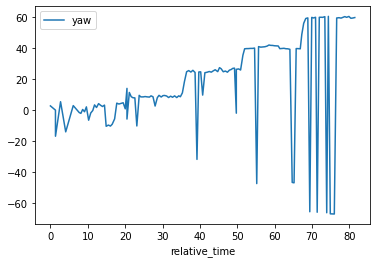

In [211]:
# initial graph
df.plot(x='relative_time', y=target)

In [212]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 5)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [213]:
# the amount of data points we are left with
len(x[peaks])

25

In [214]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

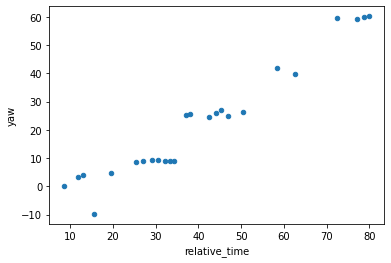

In [215]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [216]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
10,8.627297,0.301410,0
16,11.810623,3.236722,0
18,12.887048,4.056358,0
23,15.509069,-9.757892,0
29,19.472705,4.612031,15
41,25.335566,8.622368,15
44,26.928829,9.062506,15
48,29.064246,9.397319,15
51,30.562255,9.313826,15
54,32.182975,8.860323,15


In [217]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [218]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>9].index)

In [219]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [220]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
10,8.627297,0.301410,0,-0.301410
16,11.810623,3.236722,0,-3.236722
41,25.335566,8.622368,15,6.377632
44,26.928829,9.062506,15,5.937494
63,37.009989,25.344514,30,4.655486
65,38.124141,25.533768,30,4.466232
104,58.490756,41.843782,45,3.156218
111,62.498979,39.721669,45,5.278331
130,72.407238,59.722790,60,0.277210
139,77.213850,59.435423,60,0.564577


In [221]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,3.0,-2.531497,1.974314,-4.056358,-3.646540,-3.236722,-1.769066,-0.301410
15,7.0,5.943555,0.261492,5.602681,5.799951,5.937494,6.043587,6.377632
30,7.0,4.248762,0.858445,2.753168,3.834900,4.466232,4.803496,5.245138
45,2.0,4.217274,1.500561,3.156218,3.686746,4.217274,4.747802,5.278331
60,4.0,0.114679,0.374589,-0.239446,-0.167581,0.066792,0.349052,0.564577


In [222]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

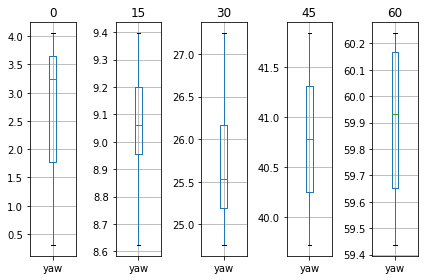

In [223]:
box_plotter(target)

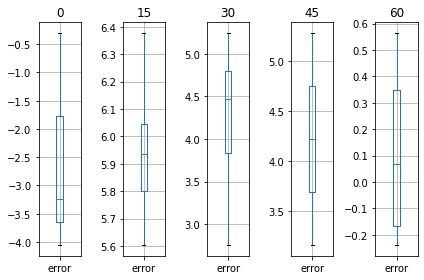

In [224]:
box_plotter('error')